In [1]:
import findspark
findspark.init()
import pyspark
from random import random
from pyspark import SparkContext
import numpy as np
from math import sqrt

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 
from pyspark.sql import SQLContext
from pyspark.sql.functions import  col

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '8')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]

4139 sic417


In [3]:
sc = pyspark.SparkContext(appName="Project 8", master='spark://polyp1:7077',conf = config )

In [4]:
###data input
rdd = sc.textFile("flights.csv")# raw data
head1=rdd.first()
splited=rdd.filter(lambda x: x!=head1).map(lambda x:x.split(','))
data1 = sc.textFile("project2Input.csv")# data after cleaning and processing
header=data1.first()
data=data1.filter(lambda x: x!=header).map(lambda x:x.split(','))

# Visualization and Analysis

## 1. cancellation rate and percentage

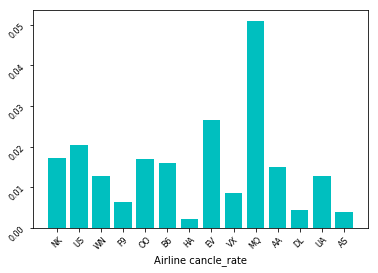

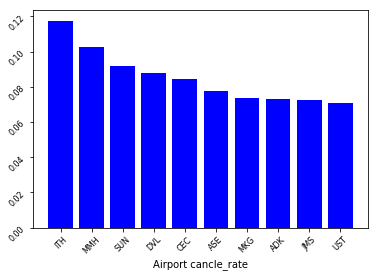

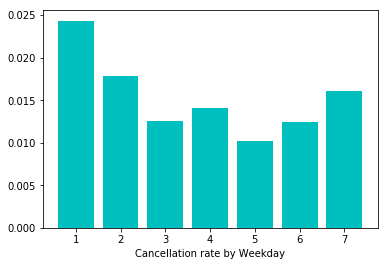

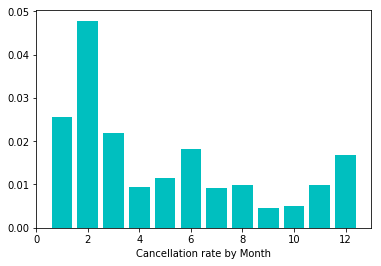

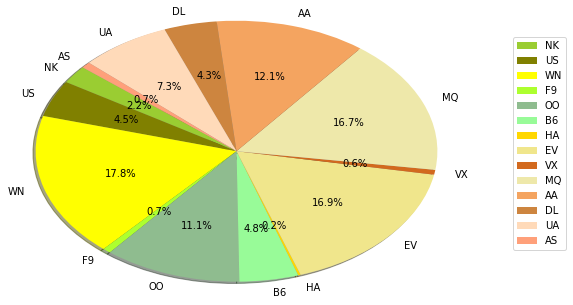

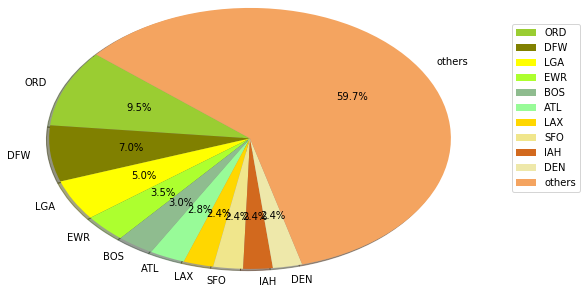

In [10]:
colors=['yellowgreen','olive','yellow','greenyellow','darkseagreen','palegreen','gold',\
        'khaki','chocolate','palegoldenrod','sandybrown','peru','peachpuff','lightsalmon']

def fill(x):
    result=0 if x =='' else float(x)
    return result
###########Cancel rate by airline
cancle_rate_airline=splited.map(lambda x: [x[4],np.array([float(x[24]),1])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1][0]/x[1][1]))
###########Cancel rate by airport
cancle_rate_ORIairport=splited.filter(lambda x:x[1]!='10').map(lambda x: [x[7],np.array([float(x[24]),1])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: [x[0],x[1][0]/x[1][1]])

p1=cancle_rate_airline.collect()
p2=cancle_rate_ORIairport.takeOrdered(10,lambda x:-x[1])

plt.bar([i[0] for i in p1],[i[1] for i in p1],color = 'c')
plt.xlabel("Airline cancle_rate",fontsize=10)
plt.tick_params(labelsize=8,rotation=45)
plt.show()

plt.bar([i[0] for i in p2],[i[1] for i in p2],color = 'b')
plt.xlabel("Airport cancle_rate",fontsize=10)
plt.tick_params(labelsize=8,rotation=45)
plt.show()
###########Cancel rate by Weekday
aaa=splited.map(lambda x: [float(x[3]),np.array([fill(x[24]),1])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1][0]/x[1][1])).collect()

plt.bar([i[0] for i in aaa],[i[1] for i in aaa],color = 'c')
plt.xlabel("Cancellation rate by Weekday",fontsize=10)
plt.show()

###########Cancel rate by Month
aaa=splited.map(lambda x: [float(x[1]),np.array([fill(x[24]),1])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1][0]/x[1][1])).collect()

plt.bar([i[0] for i in aaa],[i[1] for i in aaa],color = 'c')
plt.xlabel("Cancellation rate by Month",fontsize=10)
plt.show()
#### Percentage of canceled flights by airline and airport
totalcancel=splited.map(lambda x: float(x[24])).reduce(lambda x,y: x+y)
cancel_ratio_airline=splited.map(lambda x: [x[4],float(x[24])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1]/totalcancel)).collect()

cancel_ratio_ORIairport=splited.map(lambda x: [x[7],float(x[24])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1]/totalcancel)).takeOrdered(10,lambda x:-x[1])


labels = [i[0] for i in cancel_ratio_airline]
sizes = [i[1] for i in cancel_ratio_airline]

plt.pie(sizes, labels=labels,radius=1.5,autopct='%1.1f%%',shadow=True, startangle=140,colors=colors)
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()

labels = [i[0] for i in cancel_ratio_ORIairport]+["others"]
sizes = [i[1] for i in cancel_ratio_ORIairport]+[1-sum([i[1] for i in cancel_ratio_ORIairport])]
plt.pie(sizes, labels=labels,radius =1.5,colors=colors[:11],autopct='%1.1f%%',shadow=True, startangle=140)
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()

 ## 2. Delay rate and percentage

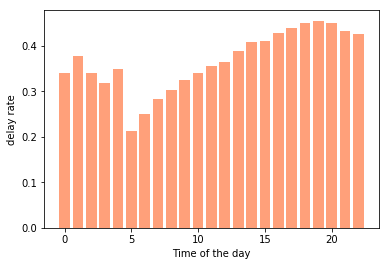

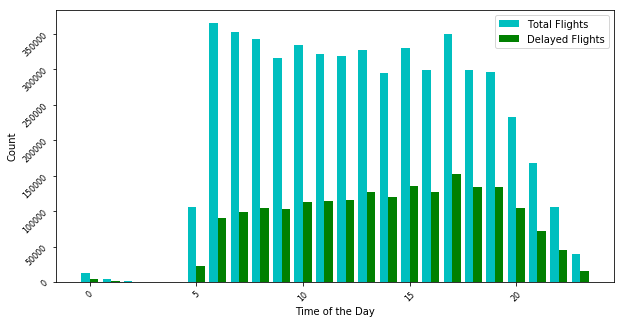

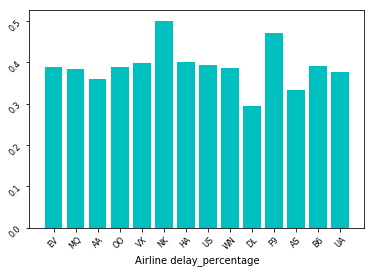

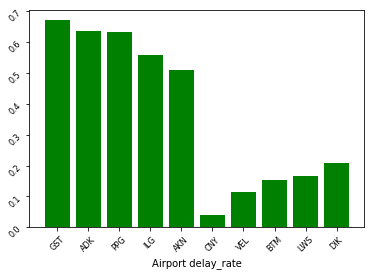

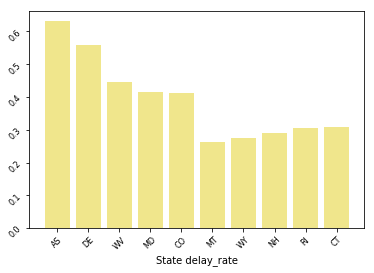

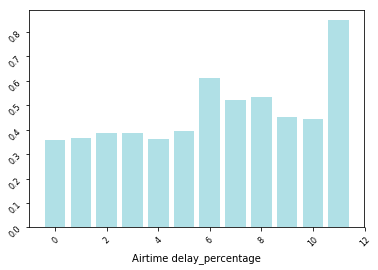

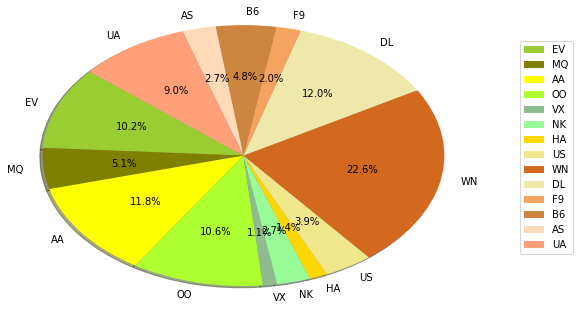

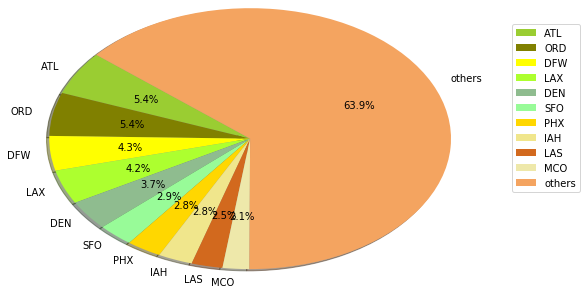

In [11]:
def fun(x):
    if len(x)<3:
        return 0;
    if len(x)==3:
        return float(x[0]);
    else:
        return float(x[:2])
data.map(lambda x: (fun(x[8]),1)).reduceByKey(lambda x,y:x+y).collect()

Airline_hour=data.map(lambda x: (fun(x[8]),1)).reduceByKey(lambda x,y:x+y).collect()
delayed=data.filter(lambda x: x[-1]=='1.0').map(lambda x: (fun(x[8]),1)).reduceByKey(lambda x,y:x+y).collect()

### Delay rate by day of time
a=[]
for i in range(23):
    a=a+[[delayed[i][0],delayed[i][1]/float(Airline_hour[i][1])]]

plt.bar([i[0] for i in a],[i[1] for i in a],color='lightsalmon')
plt.ylabel('delay rate')
plt.xlabel('Time of the day')
plt.show()
### Total flights and delayed flights by time of the day
fig = plt.figure(figsize=(10,5))
plt.bar([i[0]-0.2 for i in Airline_hour],[i[1] for i in Airline_hour],color = 'c',width=0.4,label='Total Flights')

plt.bar([i[0]+0.2 for i in delayed],[i[1] for i in delayed],color = 'g',width=0.4,label='Delayed Flights')
plt.xlabel("Time of the Day",fontsize=10)
plt.ylabel('Count')

plt.tick_params(labelsize=8,rotation=45)
plt.legend()
plt.show()

####### Delay rate by airline and airport
without10=data.filter(lambda x: x[1]!='10')
delay_percentage_airline=without10.map(lambda x: [x[4],np.array([float(x[-1]),1.0])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: [x[0],x[1][0]/x[1][1]])

delay_percentage_ORIairport=without10.map(lambda x: [x[6],np.array([float(x[-1]),1.0])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: [x[0],x[1][0]/x[1][1]])

p3=delay_percentage_airline.collect()
p4=delay_percentage_ORIairport.takeOrdered(5,lambda x:-x[1])+delay_percentage_ORIairport.takeOrdered(5,lambda x:x[1])

plt.bar([i[0] for i in p3],[i[1] for i in p3],color = 'c')
plt.xlabel("Airline delay_percentage",fontsize=10)
plt.tick_params(labelsize=8,rotation=45)
plt.show()

plt.bar([i[0] for i in p4],[i[1] for i in p4],color = 'g')
plt.xlabel("Airport delay_rate",fontsize=10)
plt.tick_params(labelsize=8,rotation=45)
plt.show()
####### Delay rate by States
delay_percentage_ORIstate=without10.map(lambda x: [x[27],np.array([float(x[-1]),1.0])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: [x[0],x[1][0]/x[1][1]])

p=delay_percentage_ORIstate.takeOrdered(5,lambda x:-x[1])+delay_percentage_ORIstate.takeOrdered(5,lambda x:x[1])

plt.bar([i[0] for i in p],[i[1] for i in p],color = 'khaki')
plt.xlabel("State delay_rate",fontsize=10)
plt.tick_params(labelsize=8,rotation=45)
plt.show()
####### Delay rate by Airtime
delay_percentage_airtime=without10.map(lambda x: [int(float(x[12])/60),np.array([float(x[-1]),1.0])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: [x[0],x[1][0]/x[1][1]])

p=delay_percentage_airtime.collect()#.takeOrdered(5,lambda x:-x[1])+delay_percentage_airtime.takeOrdered(5,lambda x:x[1])

plt.bar([i[0] for i in p],[i[1] for i in p],color = 'powderblue')
plt.xlabel("Airtime delay_percentage",fontsize=10)
plt.tick_params(labelsize=8,rotation=45)
plt.show()

### pie chart of delay flights percentage 
without10=data.filter(lambda x: x[1]!='10')
totaldelay=without10.map(lambda x: float(x[-1])).reduce(lambda x,y:x+y)

delay_ratio_airline=without10.map(lambda x: [x[4],float(x[-1])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1]/totaldelay)).collect()

delay_ratio_ORIairport=without10.map(lambda x: [x[7],float(x[-1])]).\
reduceByKey(lambda x,y:x+y).map(lambda x: (x[0],x[1]/totaldelay)).takeOrdered(10,lambda x:-x[1])


labels = [i[0] for i in delay_ratio_airline]
sizes = [i[1] for i in delay_ratio_airline]
plt.pie(sizes, labels=labels,radius=1.5,autopct='%1.1f%%',shadow=True, startangle=140,colors=colors)
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()

labels = [i[0] for i in delay_ratio_ORIairport]+["others"]
sizes = [i[1] for i in delay_ratio_ORIairport]+[1-sum([i[1] for i in delay_ratio_ORIairport])]
plt.pie(sizes, labels=labels,radius =1.5,colors=colors[:11],autopct='%1.1f%%',shadow=True, startangle=140)
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()

## 3. Visualization of Delay reasons

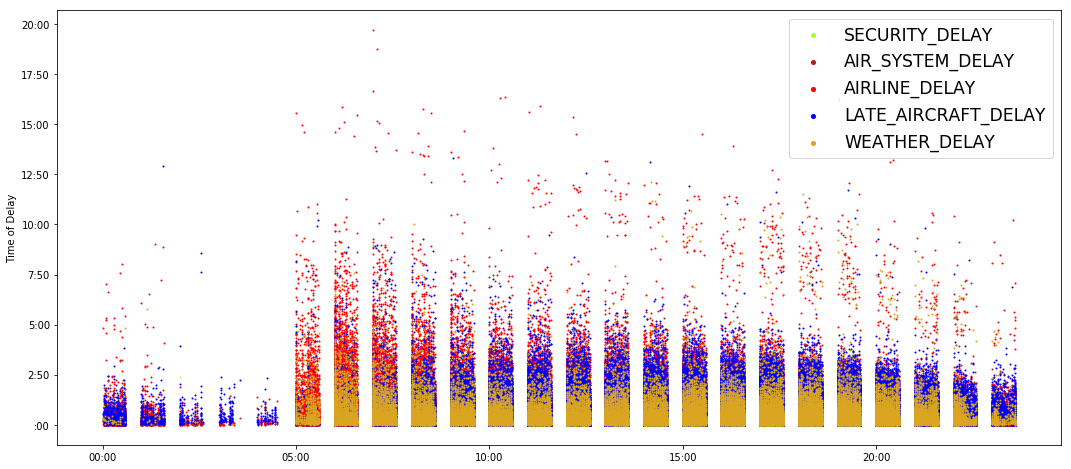

NameError: name 'mpl' is not defined

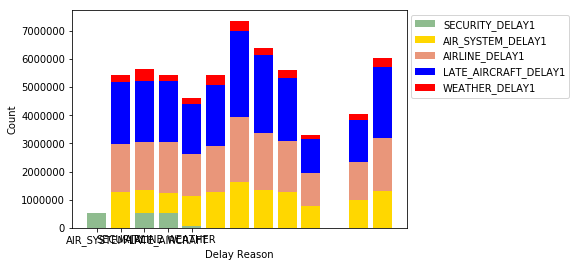

In [6]:
####### Scatter plot of delay reasons  by time of the day
colors=['yellowgreen','olive','yellow','greenyellow','darkseagreen','palegreen','gold',\
        'khaki','chocolate','palegoldenrod','sandybrown','peru','peachpuff','lightsalmon']
AIR_SYSTEM_DELAY= data.filter(lambda x:float(x[20]) > 0).map(lambda x:(float(x[8]),float(x[20]))).collect()
SECURITY_DELAY = data.filter(lambda x:float(x[21]) > 0).map(lambda x:(float(x[8]),float(x[21]))).collect()
AIRLINE_DELAY = data.filter(lambda x:float(x[22]) > 0).map(lambda x:(float(x[8]),float(x[22]))).collect()
LATE_AIRCRAFT_DELAY = data.filter(lambda x:float(x[23]) > 0).map(lambda x:(float(x[8]),float(x[23]))).collect()
WEATHER_DELAY = data.filter(lambda x:float(x[24]) > 0).map(lambda x:(float(x[8]),float(x[24]))).collect()

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(111)

ax.scatter(*zip(*SECURITY_DELAY),s=1,c=colors[3],label='SECURITY_DELAY')
ax.scatter(*zip(*AIR_SYSTEM_DELAY),s=1,c='firebrick',label='AIR_SYSTEM_DELAY')
ax.scatter(*zip(*AIRLINE_DELAY),s=1,c='r',label='AIRLINE_DELAY')
ax.scatter(*zip(*LATE_AIRCRAFT_DELAY),s=1,c='b',label='LATE_AIRCRAFT_DELAY')
ax.scatter(*zip(*WEATHER_DELAY),s=1,c='goldenrod',label='WEATHER_DELAY')
plt.xticks(range(0,2001,500), ['00:00', '05:00', '10:00', '15:00', '20:00'])
plt.yticks(range(0,2001,250), [':00', '2:50','5:00','7:50' ,'10:00', '12:50', '15:00','17:50','20:00'])
ax.set_ylabel('Time of Delay')
ax.legend(loc='best',fontsize ='xx-large',markerscale =4)
plt.show()

####### Distribution of reasons by month
AIR_SYSTEM_DELAY1= data.filter(lambda x:float(x[20]) > 0).map(lambda x:(float(x[1]),float(x[20]))).reduceByKey(lambda x,y:x+y).collect()
SECURITY_DELAY1 = data.filter(lambda x:float(x[21]) > 0).map(lambda x:(float(x[1]),float(x[21]))).reduceByKey(lambda x,y:x+y).collect()
AIRLINE_DELAY1 = data.filter(lambda x:float(x[22]) > 0).map(lambda x:(float(x[1]),float(x[22]))).reduceByKey(lambda x,y:x+y).collect()
LATE_AIRCRAFT_DELAY1 = data.filter(lambda x:float(x[23]) > 0).map(lambda x:(float(x[1]),float(x[23]))).reduceByKey(lambda x,y:x+y).collect()
WEATHER_DELAY1 = data.filter(lambda x:float(x[24]) > 0).map(lambda x:(float(x[1]),float(x[24]))).reduceByKey(lambda x,y:x+y).collect()


plt.bar(zip(*SECURITY_DELAY1)[0],zip(*SECURITY_DELAY1)[1],color='darkseagreen',label='SECURITY_DELAY1')
plt.bar(zip(*AIR_SYSTEM_DELAY1)[0],zip(*AIR_SYSTEM_DELAY1)[1],color='gold',bottom=zip(*SECURITY_DELAY1)[1],label='AIR_SYSTEM_DELAY1')
plt.bar(zip(*AIRLINE_DELAY1)[0],zip(*AIRLINE_DELAY1)[1],color='darksalmon',bottom=np.array(zip(*AIR_SYSTEM_DELAY1)[1])+\
        np.array(zip(*SECURITY_DELAY1)[1]),label='AIRLINE_DELAY1')
plt.bar(zip(*LATE_AIRCRAFT_DELAY1)[0],zip(*LATE_AIRCRAFT_DELAY1)[1],color='b',bottom=np.array(zip(*AIRLINE_DELAY1)[1])+\
        np.array(zip(*AIR_SYSTEM_DELAY1)[1])+\
        np.array(zip(*SECURITY_DELAY1)[1]),label='LATE_AIRCRAFT_DELAY1')
plt.bar(zip(*WEATHER_DELAY1)[0],zip(*WEATHER_DELAY1)[1],color='r',bottom=np.array(zip(*LATE_AIRCRAFT_DELAY1)[1])+\
        np.array(zip(*AIRLINE_DELAY1)[1])+\
        np.array(zip(*AIR_SYSTEM_DELAY1)[1])+\
        np.array(zip(*SECURITY_DELAY1)[1]),label='WEATHER_DELAY1')
plt.legend(bbox_to_anchor=(1.5,1))
plt.xlabel('Month')
plt.ylabel('Time of Delay')

###### Counts of delay reasons
AIR_SYSTEM_DELAY1= data.filter(lambda x:float(x[20]) > 0).count()
SECURITY_DELAY1 = data.filter(lambda x:float(x[21]) > 0).count()
AIRLINE_DELAY1 = data.filter(lambda x:float(x[22]) > 0).count()
LATE_AIRCRAFT_DELAY1 = data.filter(lambda x:float(x[23]) > 0).count()
WEATHER_DELAY1 = data.filter(lambda x:float(x[24]) > 0).count()
plt.bar(['AIR_SYSTEM','SECURITY','AIRLINE','LATE_AIRCRAFT','WEATHER'],\
        [AIR_SYSTEM_DELAY1,SECURITY_DELAY1,AIRLINE_DELAY1,LATE_AIRCRAFT_DELAY1,WEATHER_DELAY1],color='darkseagreen',label='SECURITY_DELAY1')
plt.xlabel('Delay Reason')
plt.ylabel('Count')

####### PIE CHART delay percentage caused by different reasons
WEATHER_DELAY = data.filter(lambda x:float(x[24])>0)
WEATHER_DELAYcount=WEATHER_DELAY.count()
WEATHER_DELAYbymonth = WEATHER_DELAY.groupBy(lambda x:x[1]).map(lambda x:(x[0],len([i for i in x[1]]))).collect()
WEATHER_DELAYbystate= data.filter(lambda x:float(x[24])>0).groupBy(lambda x:x[27]).\
map(lambda x:(x[0],len([i for i in x[1]]))).collect()
LATE_AIRCRAFT_DELAY = data.filter(lambda x:float(x[23])>0)
LATE_AIRCRAFT_DELAYcount=LATE_AIRCRAFT_DELAY.count()
AIRLINE_DELAY = data.filter(lambda x:float(x[22])>0)
AIRLINE_DELAYcount=AIRLINE_DELAY.count()

SECURITY_DELAY = data.filter(lambda x:float(x[21])>0)
SECURITY_DELAYcount=SECURITY_DELAY.count()

AIR_SYSTEM_DELAY = data.filter(lambda x:float(x[20])>0)
AIR_SYSTEM_DELAYcount=AIR_SYSTEM_DELAY.count()
WEATHER_DELAYsum=WEATHER_DELAY.map(lambda x:float(x[24])).sum()
LATE_AIRCRAFT_DELAYsum=LATE_AIRCRAFT_DELAY.map(lambda x:float(x[23])).sum()
AIRLINE_DELAYsum=AIRLINE_DELAY.map(lambda x:float(x[22])).sum()
SECURITY_DELAYsum=SECURITY_DELAY.map(lambda x:float(x[21])).sum()
AIR_SYSTEM_DELAYsum=AIR_SYSTEM_DELAY.map(lambda x:float(x[20])).sum()
TOTAL_DELAY_sum=data.filter(lambda x:float(x[16])>0).map(lambda x:float(x[16])).sum()
labels=['Weather','Late Aircraft',"Airline",'Security',"Air System"]
sizes=[WEATHER_DELAYsum/TOTAL_DELAY_sum,LATE_AIRCRAFT_DELAYsum/TOTAL_DELAY_sum,AIRLINE_DELAYsum/TOTAL_DELAY_sum,SECURITY_DELAYsum/TOTAL_DELAY_sum,AIR_SYSTEM_DELAYsum/TOTAL_DELAY_sum]
explode=(0.1,0.1,0.1,0.1,0.1)
mpl.rcParams['font.size'] = 20.0
colors=['lightslategray','dodgerblue','lightblue','deepskyblue','royalblue']
fig1,ax1=plt.subplots(figsize=(8,8))
ax1.pie(sizes,colors=colors,labels=labels,autopct='%1.2f%%',shadow=True,explode=explode,startangle=90,center=(0,0))
ax1.axis('equal')
plt.show()

## 4. Clustering airports by Kmeans

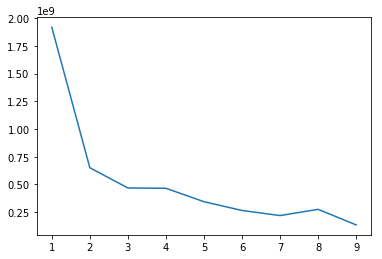



[array([  39.41181915, -106.7094809 ]), array([  29.3259542 , -156.08854959]), array([  37.37181844, -118.67912561]), array([ 38.95289851, -75.43606897]), array([ 31.19368764, -88.90553234]), array([ 41.87527073, -88.26344989])]


[(0, 0.3699236233012869), (1, 0.35367882725887523), (2, 0.3877732490250942), (3, 0.36520304851626173), (4, 0.37052943556211076), (5, 0.3663222630935452)]


[(0, 0.028647568287808126), (1, 0.01653956620778449), (2, 0.011824570015635794), (3, 0.030769147604877006), (4, 0.0422682723556018), (5, 0.04576968474611233)]


[(0, u'Denver International Airport'), (1, u'Honolulu International Airport'), (2, u'Los Angeles International Airport'), (3, u'Gen. Edward Lawrence Logan International Airport'), (4, u'Hartsfield-Jackson Atlanta International Airport'), (5, u"Chicago O'Hare International Airport")]


[(0, [u'CO', u'NM', u'TX', u'UT', u'ND', u'NE', u'KS', u'MT', u'OK', u'AZ', u'ID', u'WY', u'SD']), (1, [u'AS', u'AK', u'HI', u'GU']), (2, [u'WA', u'UT', u'CA', u'OR

In [14]:
## Kmeans to cluster the progin airports / Choose the best k

location = data.map(lambda x:(float(x[28]),float(x[29])))
from pyspark.mllib.clustering import KMeans, KMeansModel
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sum([x**2 for x in (point - center)])
ks=[]
es=[]
for k in range(1,10,1):
    clusters = KMeans.train(location, k, maxIterations=10, initializationMode="random", seed=100)
    WSSSE = location.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    ks.append(k)
    es.append(WSSSE)
plt.plot(ks,es)
plt.show()

print '\n'
##Cluster origin airports using 7 clusters
clusters7 = KMeans.train(location, 7, maxIterations=10, initializationMode="random", seed=100)
print clusters7.clusterCenters
print '\n'
##Delay Rate in each cluster
print data.map(lambda x:(clusters7.predict((float(x[28]),float(x[29]))),x[35])).\
groupByKey().map(lambda x:(x[0],(float([i for i in x[1]].count('1.0')) / len([i for i in x[1]])))).collect()
print '\n'
## Each cluster influenced by weather
print data.map(lambda x:(clusters7.predict((float(x[28]),float(x[29]))),x)).groupByKey().\
map(lambda x:(x[0],float(sum([float(i[24])>0 for i in x[1]]))/float(([i[35] for i in x[1]].count('1.0'))))).collect()
print '\n'
## Busiest airports in each cluster
print data.map(lambda x:(clusters7.predict((float(x[28]),float(x[29]))),x[25])).groupByKey().\
map(lambda x:(x[0],max(set([i for i in x[1]]), key = [i for i in x[1]].count))).collect()
print '\n'
## State contained in each cluster
print data.map(lambda x:(clusters7.predict((float(x[28]),float(x[29]))),x[27])).groupByKey().\
map(lambda x:(x[0],list(set([i for i in x[1]])))).collect()